In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

In [2]:
# priors
prior_mu = 0
prior_var = 1

# data
K = 3
N = 1000
means = np.array([-3,0,3])
c_data = np.array([np.random.choice(np.arange(K,dtype=int))
                   for n in range(N)])
x_data = np.array([np.random.normal(loc=means[c],scale=np.sqrt(prior_var))
                   for c in c_data])

/ext/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


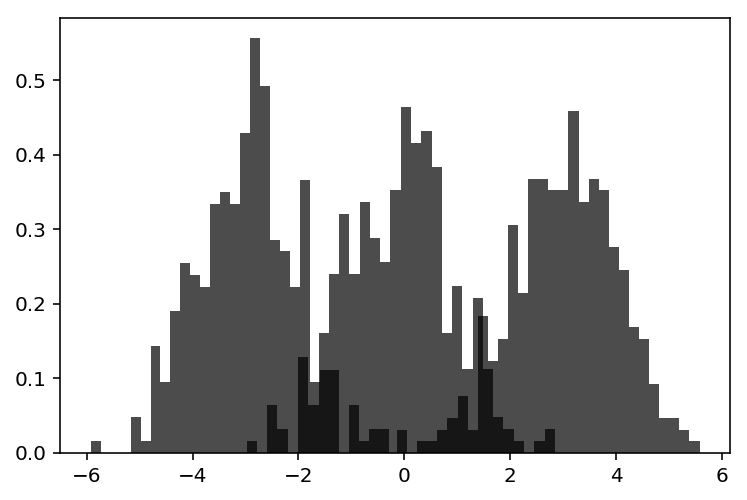

In [9]:
colors = ['k','k','k']
for i,c in enumerate(colors):
    plt.hist(x_data[c_data == i],bins=30,color=c,alpha=.7,normed=True)
plt.show()

/ext/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


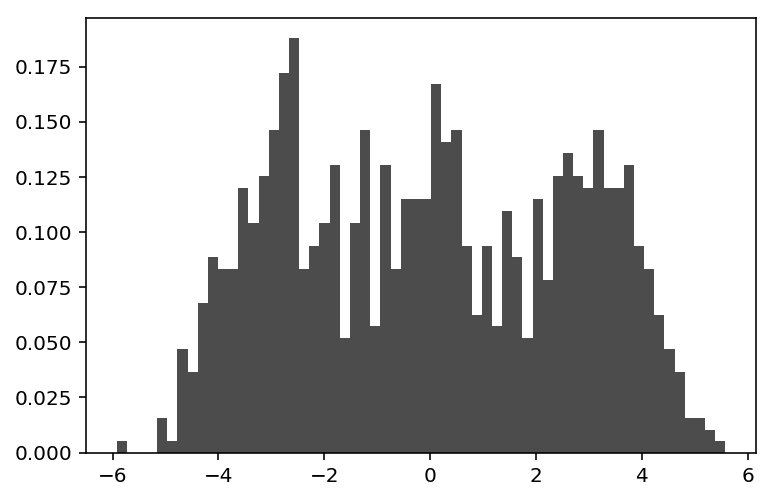

In [11]:
plt.hist(x_data,bins=60,color='k',alpha=.7,normed=True)
plt.show()

In [4]:
class CAVI():
    
    def __init__(self,data,components,prior_mu,prior_var):
        
        self.data = data
        self.N = data.shape[0] # number of data points
        self.K = components
        self.p_mu = prior_mu
        self.p_var = prior_var
        
        # initialize variational parameters
        self.m = np.random.normal(size=self.K) # hyper means
        self.s = 10*np.ones(shape=self.K) # hyper variances 
        
        # parameters for multinomial distribution
        self.p = np.array([(1./self.K)*np.ones(shape=self.K) for x in range(self.N)])
        
        
    def run_cavi(self,max_steps = 100,tolerance=1e-6):
        # run CAVI for max_steps, break early for convergence
#         return('Write CAVI Code')
        self.elbos = [self.calc_elbo()]
        
        for step in range(max_steps): # update variational parameters
        
            for n in range(self.N): # multinomial params
                self.update_p(n)
            
            for k in range(self.K): # normal params
                self.update_k(k)
                
            self.elbos.append(self.calc_elbo())
            improvement = (self.elbos[-1] - self.elbos[-2])/abs(self.elbos[-2])
            if improvement < tolerance:
                break
                
    def calc_elbo(self):
        # calculate the ELBO, from Blei Notes on VI
        
        # eq 52 
        sum_log_u = (-self.N*(.5*np.log(2*np.pi*self.p_var))
                     - sum((self.s + self.m**2)/(2*self.p_var))
                     + sum((self.m*self.p_mu)/self.p_var)
                     - self.N*(self.p_mu/(2*self.p_var))
                    )
        
        sum_log_z = self.N*np.log(1./self.K) #eq 53
        
        h_q_u = sum(.5*np.log(2*np.pi*self.s))+.5*self.N #eq 54
        
        h_q_z = sum(-((self.p*np.log(self.p)).sum(axis=1))) # eq 55
        
        sum_log_x = (-.5*np.log(2*np.pi)*self.N
                    -(self.data*self.data/2.).sum()
                    +(self.p*(self.data.reshape(-1,1)*self.m)).sum()
                    -(self.p*self.s).sum()
                    -((self.p*(self.m*self.m)).sum()/(self.K*self.N*2)))
                 
        elbo = sum_log_u + sum_log_z + sum_log_x + h_q_u + h_q_z
        return(elbo)
                    

    def update_p(self,n):
        # set given p to marginal
        # eq 40 from Blei Notes on VI

        unnormed_p = np.exp(self.m*self.data[n] -
                           (self.s + self.m**2)/2)
        self.p[n] = unnormed_p / sum(unnormed_p)

    def update_k(self,k):
        # set hyperparameters of cluster k to marginals
        # eqs 50 & 51 from Blei Notes on VI

        self.m[k] = ( self.p_mu/self.p_var + sum(self.p.T[k]*self.data) /
                    (1./self.p_var + sum(self.p.T[k])))

        self.s[k] = 1 / (1./self.p_var + sum(self.p.T[k]))


In [5]:
mgauss = CAVI(x_data,K,prior_mu,prior_var)
mgauss.run_cavi()

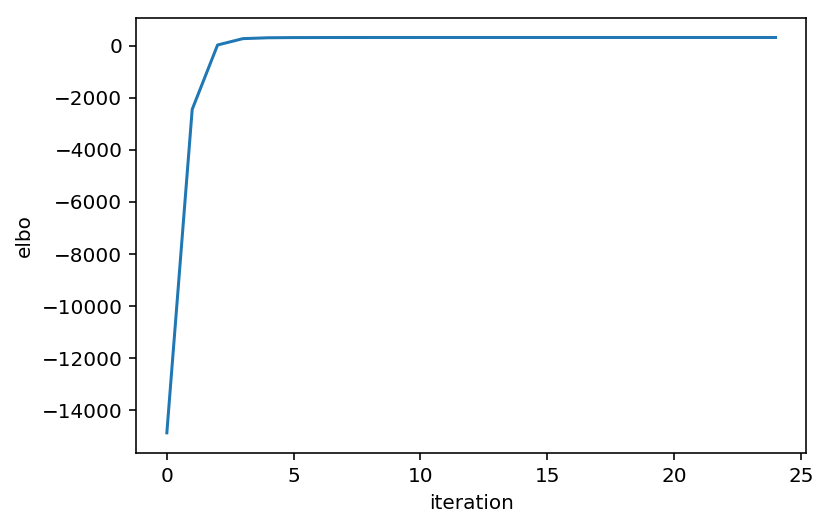

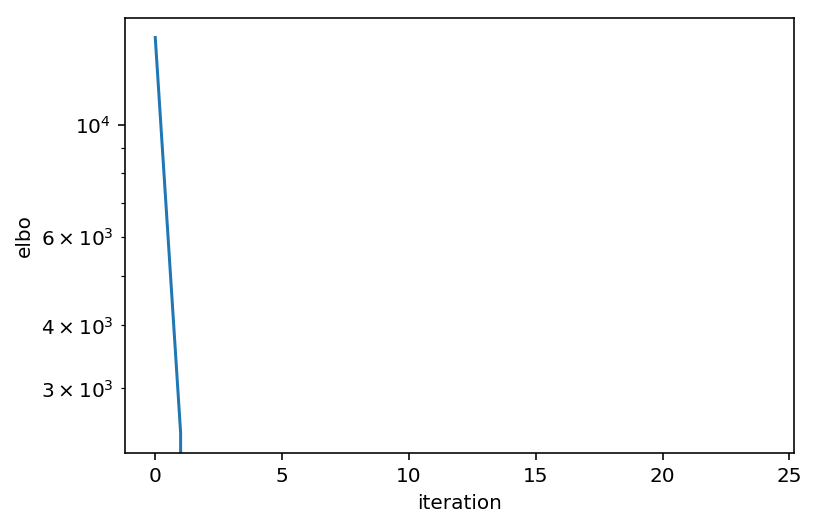

In [15]:
plt.figure()
plt.plot(mgauss.elbos)
plt.xlabel('iteration')
plt.ylabel('elbo')
plt.figure()
plt.semilogy(-np.array(mgauss.elbos))
plt.xlabel('iteration')
plt.ylabel('elbo')
plt.show()

In [7]:
sorted_means = sorted(mgauss.m)
print('estimated means: %s'%np.round(sorted_means,5))
c_est = np.array([sorted_means.index(mgauss.m[np.argmax(n)]) for n in mgauss.p])
print('assignment accuracy: %s'%((c_est == c_data).sum()/N))

estimated means: [-2.91032 -0.03526  3.0564 ]
assignment accuracy: 0.918


/ext/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


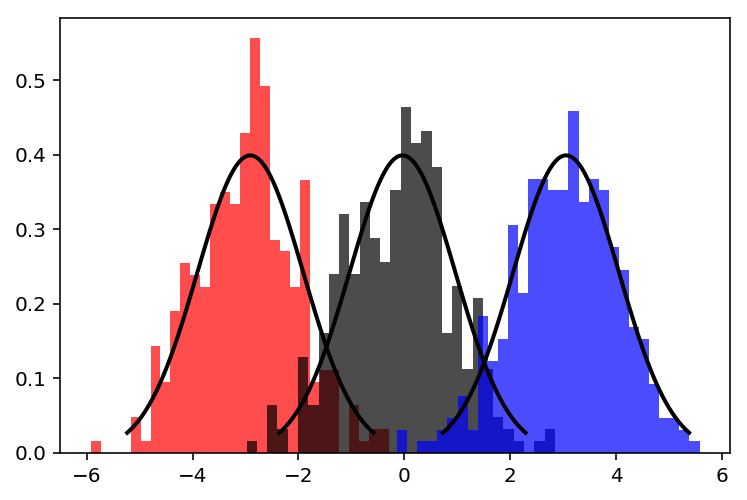

In [8]:
colors = ['r','k','b']
for i,c in enumerate(colors):
    plt.hist(x_data[c_data == i],bins=30,color=c,alpha=.7,normed=True)
for mean in sorted_means:
    norm = ss.norm(loc=mean,scale=np.sqrt(prior_var))
    inputs = np.linspace(norm.ppf(0.01),
                    norm.ppf(0.99), 100)
    plt.plot(inputs,norm.pdf(inputs),c='k',lw=2)
plt.show()